# Lesson 2 - Random forest deep dive

> A deep dive into how Random Forests work and some tricks for making them more performant.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson02_random-forest-deep-dive.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson02_random-forest-deep-dive.ipynb)

## Learning objectives

* Understand how to go from simple to complex models
* Understand the concepts of bagging and out-of-bag score
* Gain an introduction to hyperparameter tuning

## References

* Chapters 2 & 3 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron

## The data

We will continue our analysis of the [SUSY dataset](http://archive.ics.uci.edu/ml/datasets/SUSY#) from lesson 1, but this time focus on the sample of 100,000 events that we created:

* `susy_sample.f`

By using a random sample, we can iterate faster in our exploration and save the training of a model on the full dataset until a later stage.

## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
from hepml.core import display_large, download_dataset

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.tree import plot_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy
from scipy.cluster import hierarchy as hc

## Load the data

As usual, we can download our datasets by using our `download_dataset` helper function:

In [ ]:
download_dataset("susy.f")

KeyError: 'File not on Google Drive.'

We also make use of the `pathlib` library to handle our filepaths:

In [ ]:
DATA = Path("../data")
!ls {DATA}

susy.csv.gz   susy.f        susy_sample.f


With pathlib it is a simple matter to define the filepath to the dataset, and since the file is in CSV format we can load it as a `pandas.DataFrame` as follows:

In [ ]:
susy_sample = pd.read_feather(DATA / "susy_sample.f")
susy_sample.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.691280,1.769201,-1.711811,0.476238,1.540563,-0.267858,0.872984,0.278745,1.087132,-0.551878,0.512544,0.891626,1.543717,0.860364,0.583060,0.691560,1.500089,0.559077
1,0.0,0.417667,-1.888612,-0.225399,0.572387,-1.194098,0.070454,0.695429,1.663371,1.043925,-0.382097,0.427828,0.809541,1.679137,1.760872,0.439944,1.310742,1.367967,0.191391
2,1.0,0.274744,-1.383963,-1.033036,0.439080,1.670371,-0.675462,0.748248,0.907954,1.123212,-0.434616,0.900805,0.702888,0.692425,1.529867,0.932529,1.168535,1.545469,0.002309
3,1.0,1.165006,1.004205,-1.223371,1.627817,-0.376755,0.839448,2.003187,1.606087,2.768745,2.292744,1.515240,1.375575,0.805598,0.000000,1.529152,1.256361,1.523800,0.004668
4,1.0,1.404497,-0.145557,0.052160,0.655964,1.246058,1.403647,0.671340,-1.685370,0.629945,-0.338737,1.190204,1.109146,0.826956,0.759544,1.145565,1.110235,0.260206,0.326079


In lesson 1 we focused on building a simple Random Forest model for just the 8 "low" features, i.e. the purely kinematic quantities. Here we will consider _all_ features and leave the analysis of the pure "low" and "high" features as an exercise.

To that end, we can create a feature matrix $X$ and target vector $y$ and train/validation splits as before:

In [ ]:
X = susy_sample.drop("signal", axis=1)
y = susy_sample["signal"]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print(f"Dataset split: {len(X_train)} train rows + {len(X_valid)} valid rows")

Dataset split: 80000 train rows + 20000 valid rows


## Baseline model

As a sanity check, let's see how our baseline model performs on the validation set:

In [ ]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [ ]:
print_scores(model)

Accuracy on train: 0.985
ROC AUC on train: 0.999
Accuracy on valid: 0.782
ROC AUC on valid: 0.84


As we found with the "low" features in lesson 1, this simple model falls short of the Boosted Decision Tree benchmark by a few percent (see table):

<div style="text-align: center">
<img src='images/susy_benchmark.png'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://www.nature.com/articles/ncomms5308 </p>
</div>

## The simplest model: a single tree

Let's build a model that is so simple that we can actually take a look at it. As we saw in lesson 1, a Random Forest is simply a forest of decision trees, so let's begin by looking at a single tree (called estimators in scikit-learn):

In [ ]:
model = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In the above we have fixed the following hyperparameters:

* `n_estimators = 1`: create a forest with one tree, i.e. a _decision tree_
* `max_depth = 3`: how deep or the number of "levels" in the tree
* `bootstrap = False`: this setting ensures we use the whole dataset to build the tree
* `n_jobs = -1`: this parallelises the computation over all CPU cores
* `random_state = 42`: this sets the random seed so our results are reproducible

Let's see how this simple model performs:

In [ ]:
print_scores(model)

Accuracy on train: 0.743
ROC AUC on train: 0.781
Accuracy on valid: 0.748
ROC AUC on valid: 0.786


Unsurprisingly, this single tree yields worse predictions (accuracy 74.8%) than our baseline with 10 trees (accuracy 78.2%). Nevertheless, we can visualise the tree by accessing the `estimators_` attribute and making use of scikit-learn's plotting API ([link](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)):

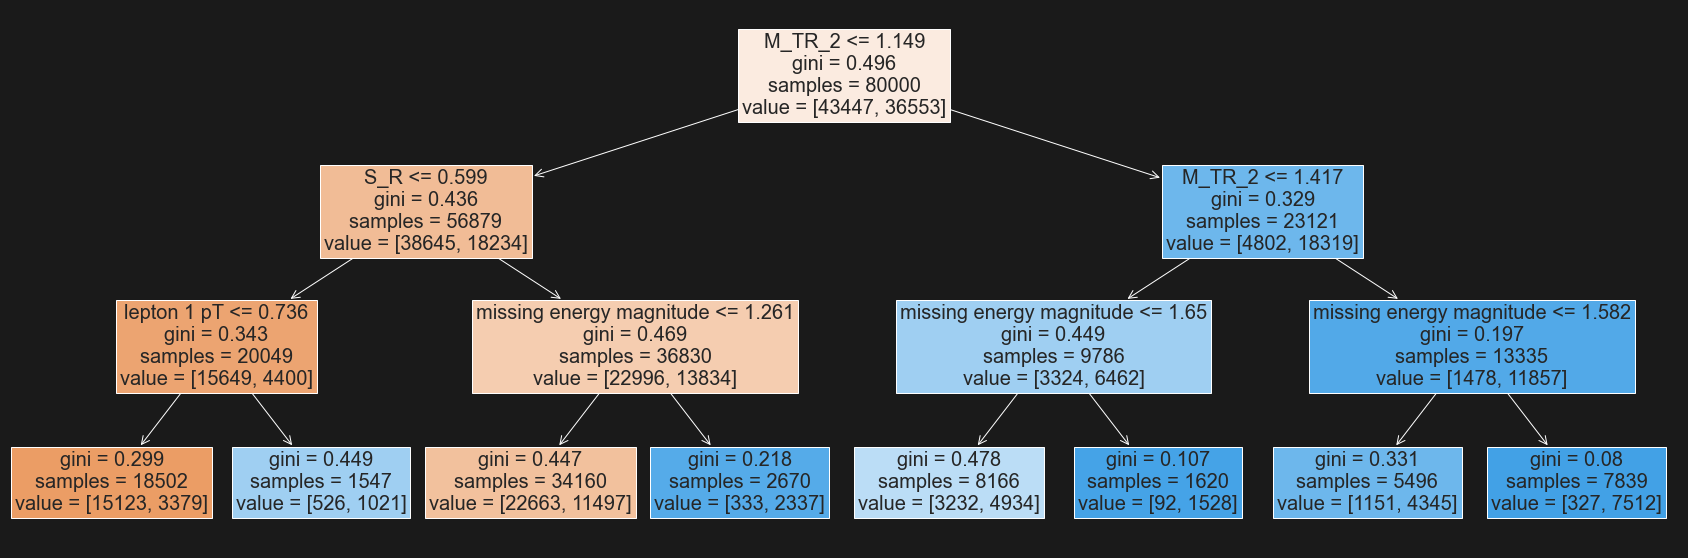

In [ ]:
# get column names
feature_names = X_train.columns
# we need to specify the background color because of a quirk in sklearn
fig, ax = plt.subplots(figsize=(30, 10), facecolor="k")
# generate tree plot
plot_tree(model.estimators_[0], filled=True, feature_names=feature_names, ax=ax, fontsize=20)
plt.show()

From the figure we observe that a tree consists of a sequence of binary decisions, where each box includes information about:

* The binary split criterion (mean squared error (mse) in this case)
* The number of `samples` in each node. Note we start with the full dataset in the root node and get successively smaller values at each split.
* Darker colours indicate a higher `value`, where `value` refers to the _average_ of of the prices. 
* The best single binary split is for `M_TR_2 <= 1.149` which reduces the Gini impurity from 0.496 in the root node to 0.436 (0.329) in the depth-1 left (right) node.

## Increasing the tree depth

Right now our simple tree model has an accuracy of 74.8% on the validation set - let's try to make better by removing the `max_depth=3` restriction:

In [ ]:
model = RandomForestClassifier(n_estimators=1, bootstrap=False, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
print_scores(model)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.71
ROC AUC on valid: 0.708


Note that removing the `max_depth` constraint has yielded a _perfect_ accuracy on the training set! That is because in this case each leaf node has exactly one element, so we can perfectly segment the data. We also have an accuracy of 71% on the validation set which is worse than our shallow tree, so let's look at some techniques to improve it.

## Introduction to bagging

Bagging is a technique that can be used to improve the ability of models to generalise to new data.

The basic idea between bagging is to consider training _several_ models, each of which is only partially predictive, but crucially, uncorrelated. Since these models are effectively gaining different insights into the data, by averaging their predictions we can create an _ensemble_ that is more predictive!

As shown in the figure, bagging is a two-step process:

1. Bootstrapping, i.e. sampling the training set
2. Aggregation, i.e. averaging predictions from multiple models

This gives us the acronym Bootstrap AGGregatING, or bagging for short 🤓.

The key for this to work is to ensure the errors of each mode are uncorrelated, so the way we do that with trees is to _**sample with replacement**_ from the data: this produces a set of independent samples upon which we can train our models for the ensemble.
<div style="text-align: center">
<img src='./images/bagging.png' width='700'>
<p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/33tGPVT </p>
</div>

## Hyperparameter tuning

If we revisit our very first model, we saw that the number of trees (`n_estimators`) is one of the parameters we can tune when building our Random Forest. Let's look at this more closely and see how the performance of the forest improves as we add trees.

In [ ]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

After training, each tree is stored in an attribute called `estimators_`. For each tree, we can call `predict()` on the validation set and use the `numpy.stack()` function to concatenate the predictions together:

In [ ]:
preds = np.stack([tree.predict(X_valid) for tree in model.estimators_])

Since we have 10 trees and 20,000 samples in our validation set, we expect that `preds` will have shape $(n_\mathrm{trees}, n_\mathrm{samples})$:

In [ ]:
preds.shape

(10, 20000)

Let's now look at a plot of the accuracy as we increase the number of trees:

In [ ]:
def plot_accuracy_vs_trees(preds, y_valid):
    """Generate a plot of ROC AUC scores on validation set vs number of trees in Random Forest"""
    fig, ax = plt.subplots()
    plt.plot(
        [
            accuracy_score(y_valid, stats.mode(preds[: i + 1], axis=0)[0][0])
            for i in range(len(preds) + 1)
        ]
    )
    ax.set_ylabel("Accuracy on validation set")
    ax.set_xlabel("Number of trees")

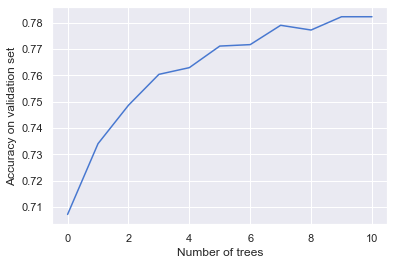

In [ ]:
plot_accuracy_vs_trees(preds, y_valid)

As we add more trees, the accuracy improves but appears to flatten out. Let's test this numerically.

In [ ]:
for n_estimators in [20, 40, 80, 160]:
    print(f"Number of trees: {n_estimators}\n")
    model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    print_scores(model)
    print("="*50, "\n")

Number of trees: 20

Accuracy on train: 0.996
ROC AUC on train: 1.0
Accuracy on valid: 0.789
ROC AUC on valid: 0.854

Number of trees: 40

Accuracy on train: 0.999
ROC AUC on train: 1.0
Accuracy on valid: 0.794
ROC AUC on valid: 0.861

Number of trees: 80

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.797
ROC AUC on valid: 0.864

Number of trees: 160

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.797
ROC AUC on valid: 0.866



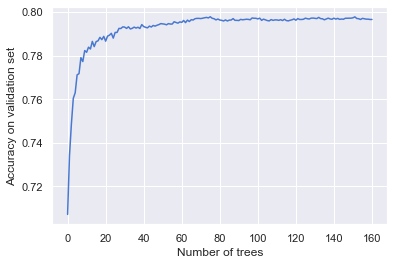

In [ ]:
preds = np.stack([tree.predict(X_valid) for tree in model.estimators_])
plot_accuracy_vs_trees(preds, y_valid)

Adding more trees slows the computation down, so we can conclude from the plot that about 100 trees is a good number to gain good performance for cheaper compute.

## Out-Of-Bag (OOB) score

So far, we've been using a validation set to examine the effect of tuning hyperparameters like the number of trees - what happens if the dataset is small and it may not be feasible to create a validation set because you would not have enough data to build a good model? Random Forests have a nice feature called _**Out-Of-Bag (OOB) error**_ which is designed for just this case!

The key idea is to observe that the first tree of our ensemble was trained on a bagged sample of the full dataset, so if we evaluate this model on the _remaining_ samples we have effectively created a _validation set per tree._ To generate OOB predictions, we can then calculate the majority class of all the trees and calculate ROC AUC, accuracy, or whatever metric we are interested in.

To toggle this behaviour in scikit-learn, one makes use of the `oob_score` flag, which adds an `oob_score_` attribute to our model that we can print out:

In [ ]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.797
ROC AUC on valid: 0.865
OOB accuracy: 0.792


OOB score is handy when you want to find the best set of hyperparameters in some automated way. For example, scikit-learn has a function called [grid search](https://scikit-learn.org/stable/modules/grid_search.html) that allows you pass a list of hyperparameters and a range of values to scan through. Using the OOB score to evaluate which combination of parameters is best is a good strategy in practice.

## More hyperparameter tuning

Let's look at a few more hyperparameters that can be tuned in a Random Forest. From our earlier analysis, we saw that 100 trees gave good performance, so let's pick that as a baseline to compare against.

In [ ]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)
model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.797
ROC AUC on valid: 0.865
OOB accuracy: 0.791


### Minimum number of samples per leaf

The hyperparameter `min_samples_leaf` controls whether or not the tree should continue splitting a given node based on the number of samples in that node. By default, `min_samples_leaf = 1`, so each tree will split all the way down to a single sample, but in practice it can be useful to work with values 3, 5, 10, 25 and see if the performance improves.

In [ ]:
for leaf_val in [3, 5, 10, 25]:
    print(f"Leaf value: {leaf_val}", "\n")
    model = RandomForestClassifier(
        n_estimators=100,
        min_samples_leaf=leaf_val,
        n_jobs=-1,
        oob_score=True,
        random_state=42,
    )
    model.fit(X_train, y_train)
    print_scores(model)
    print("="*50, "\n")

Leaf value: 3 

Accuracy on train: 0.964
ROC AUC on train: 0.997
Accuracy on valid: 0.797
ROC AUC on valid: 0.868
OOB accuracy: 0.793

Leaf value: 5 

Accuracy on train: 0.92
ROC AUC on train: 0.986
Accuracy on valid: 0.798
ROC AUC on valid: 0.869
OOB accuracy: 0.795

Leaf value: 10 

Accuracy on train: 0.871
ROC AUC on train: 0.958
Accuracy on valid: 0.799
ROC AUC on valid: 0.869
OOB accuracy: 0.796

Leaf value: 25 

Accuracy on train: 0.831
ROC AUC on train: 0.919
Accuracy on valid: 0.797
ROC AUC on valid: 0.869
OOB accuracy: 0.796



For this particular dataset, setting `min_samples_leaf = 10` improves our metrics on the validation set, so let's fix this parameter to that value.

### Maximum number of features per split

Another good hyperparameter to tune is `max_features`, which controls what _**random**_ number or fraction of _**columns**_ we consider when making a single split at a tree node. Here, the motivation is that we might have situations where a few columns in our data are highly predictive, so each tree will be biased towards picking the same splits and thus reduce the generalisation power of our ensemble. To counteract that, we can tune `max_features`, where good values to try are `1.0`, `0.5`, `log2`, or `sqrt`.

In [ ]:
for max_feat in [0.5, 1.0, 'log2', 'sqrt']:
    print(f'Max features: {max_feat}')
    model = RandomForestClassifier(
        n_estimators=100,
        min_samples_leaf=10,
        max_features=max_feat,
        n_jobs=-1,
        oob_score=True,
        random_state=42,
    )
    model.fit(X_train, y_train)
    print_scores(model)
    print("="*50, "\n")

Max features: 0.5
Accuracy on train: 0.882
ROC AUC on train: 0.965
Accuracy on valid: 0.799
ROC AUC on valid: 0.869
OOB accuracy: 0.795


Max features: 1.0
Accuracy on train: 0.888
ROC AUC on train: 0.968
Accuracy on valid: 0.796
ROC AUC on valid: 0.867
OOB accuracy: 0.794


Max features: log2
Accuracy on train: 0.871
ROC AUC on train: 0.958
Accuracy on valid: 0.799
ROC AUC on valid: 0.869
OOB accuracy: 0.796


Max features: sqrt
Accuracy on train: 0.871
ROC AUC on train: 0.958
Accuracy on valid: 0.799
ROC AUC on valid: 0.869
OOB accuracy: 0.796




Doing so with the default setting of `max_features = 'sqrt'` does not appear to help much. Nevertheless, compared to our first naive model with just 10 trees and default settings, this model achieves a ROC AUC of 0.869 on the validation set - an improvement of around 4.5%. This improvement may not sound like much, but in practice these incremental improvements can translate into high impact when aggregated over many such decisions (e.g. for event processing).

## Automate the boring stuff with cross-validation

In our analysis above we manually inspected how the performance evolved when we changed the hyperparameters of the Random Forest one at a time. Instead we can automate this process using scikit-learn's `RandomizedSearchCV` to search for the best combination of hyperparameter values:

In [ ]:
# define range of values for each hyperparameter
param_dist = [
    {
        "n_estimators": [10, 20, 40, 80, 160],
        "max_features": [0.5, 1.0, "sqrt", "log2"],
        "min_samples_leaf": [1, 3, 5, 10, 25],
    }
]

# instantiate baseline model
model = RandomForestClassifier(n_estimators=10, n_jobs=-1)

# initialise random search with cross-validation
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, cv=3, scoring="roc_auc", n_jobs=-1
)

In [ ]:
%time random_search.fit(X, y)

CPU times: user 2min 7s, sys: 979 ms, total: 2min 8s
Wall time: 3min 19s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
random_search.best_params_

{'n_estimators': 160, 'min_samples_leaf': 25, 'max_features': 'log2'}

In [ ]:
best_model = random_search.best_estimator_

In [ ]:
print_scores(best_model)

Accuracy on train: 0.83
ROC AUC on train: 0.92
Accuracy on valid: 0.831
ROC AUC on valid: 0.919


In [ ]:
susy = pd.read_feather(DATA/'susy.f')

In [ ]:
susy_test = susy.iloc[-500000:]

In [ ]:
probs = best_model.predict_proba(susy_test.drop('signal', axis=1))

In [ ]:
susy_train = susy.iloc[:-500000]

In [ ]:
susy_train.shape

(4500000, 19)

In [ ]:
model = RandomForestClassifier(n_estimators=160, min_samples_leaf=25, max_features='log2', n_jobs=-1, oob_score=True)

In [ ]:
%time model.fit(susy_train.drop('signal', axis=1), susy_train['signal'])

CPU times: user 4h 3min 45s, sys: 1min 54s, total: 4h 5min 40s
Wall time: 19min 28s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=160,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
probs = model.predict_proba(susy_test.drop('signal', axis=1))

In [ ]:
roc_auc_score(susy_test['signal'], probs[:,1])

0.8716932181454264

In [ ]:
from sklearn.model_selection import GridSearchCV

# define range of values for each hyperparameter
param_grid = [
    {
        "n_estimators": [10, 20, 40, 80, 160],
        "max_features": [0.5, 1.0, "sqrt", "log2"],
        "min_samples_leaf": [1, 3, 5, 10, 25],
    }
]

# instantiate baseline model
model = RandomForestClassifier(n_estimators=10, n_jobs=-1)

# initialise grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid=param_grid, cv=3, scoring="roc_auc", n_jobs=-1
)

In [ ]:
%time grid_search.fit(X, y)

CPU times: user 4min 30s, sys: 1.22 s, total: 4min 31s
Wall time: 24min 10s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False,
                                              random_s

In [ ]:
grid_search.best_params_

{'max_features': 0.5, 'min_samples_leaf': 25, 'n_estimators': 160}

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
print_scores(best_model)

Accuracy on train: 0.836
ROC AUC on train: 0.926
Accuracy on valid: 0.839
ROC AUC on valid: 0.927


## Feature importance

Training a model that accurately predicts outcomes is great, but most of the time you don't just need predictions, you want to be able to interpret your model. For example, if you build a model of house prices, knowing which features are most predictive of price tells us which features people are willing to pay for.

In [ ]:
def rf_feature_importance(fitted_model, df):
    return pd.DataFrame(
        {"Column": df.columns, "Importance": fitted_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

In [ ]:
# expected shape - (n_features, 2)
feature_importance = rf_feature_importance(best_model, X)

# peek at top 10 features
feature_importance[:10]

,Column,Importance
6,missing energy magnitude,0.203576
11,M_TR_2,0.167978
0,lepton 1 pT,0.145026
9,axial MET,0.097902
10,M_R,0.059224
14,S_R,0.047135
8,MET_rel,0.043954
17,cos(theta_r1),0.041153
1,lepton 1 eta,0.029804
15,M_Delta_R,0.027596


In [ ]:
def plot_feature_importance(feature_importance):
    return sns.barplot(y="Column", x="Importance", data=feature_importance, color='b')

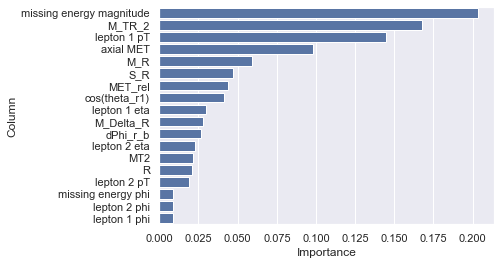

In [ ]:
plot_feature_importance(feature_importance);

In [ ]:
def plot_dendogram(X):
    """Plots a dendogram to see which features are related."""
    # calculate correlation coefficient
    corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
    # convert to distance matrix
    corr_condensed = hc.distance.squareform(1 - corr)
    # perform clustering
    z = hc.linkage(corr_condensed, method="average")
    # plot dendogram
    fig = plt.figure(figsize=(16, 10))
    dendrogram = hc.dendrogram(
        z, labels=X.columns, orientation="left", leaf_font_size=16
    )
    plt.show()

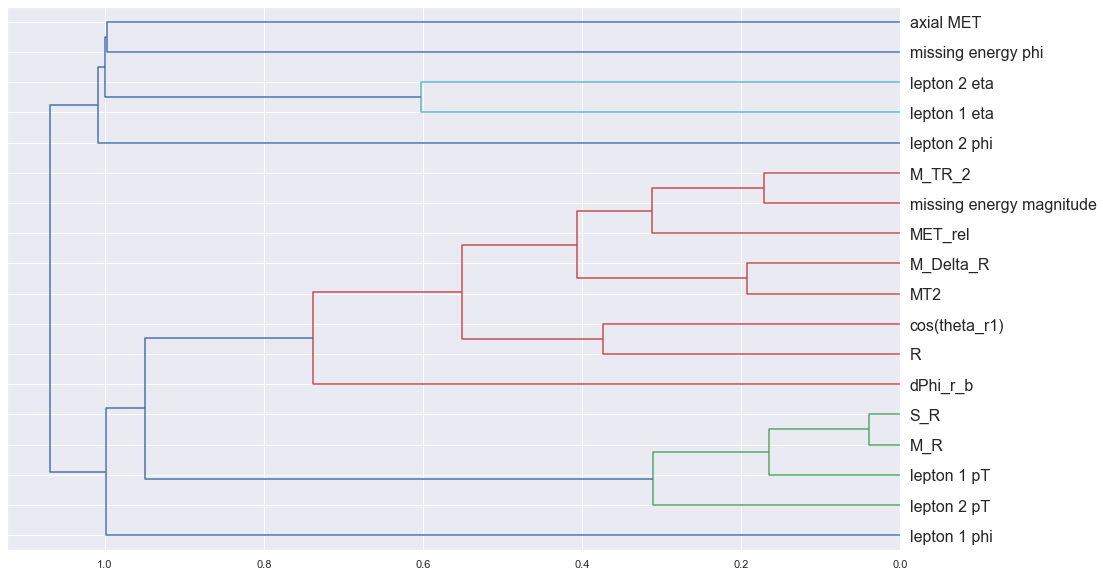

In [ ]:
plot_dendogram(X)